In [2]:
import sys, os, time
#%load_ext autoreload
#%autoreload 2
import torch
import torch.nn.functional as F
from torch.autograd import grad
import torch.distributions as distrib
import torch.nn as nn
import torch.utils.data as td
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms
import gym
import numpy as np
#%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
#from envs import Discrete_Pos_Trap, Gym_Env, Print_Env
from torch.distributions.utils import lazy_property
import foundation as fd
from foundation import nets
from foundation.util import replicate, Cloner
import torch.multiprocessing as mp
import time

In [3]:
traindata = MNIST('/mnt/c/Users/anwan/Documents/mnist/', download=True, transform=transforms.ToTensor())
testdata = MNIST('/mnt/c/Users/anwan/Documents/mnist/', train=False, download=True, transform=transforms.ToTensor())

In [4]:
loader = DataLoader(traindata, shuffle=True, batch_size=64)
print(len(traindata), len(testdata), len(loader))

60000 10000 938


In [5]:
model = nets.make_MLP(input_dim=28*28, output_dim=10, hidden_dims=[64], nonlin='elu')
optim = nets.get_optimizer(optim_type='adam', parameters=model.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
total_epochs = 0
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ELU(alpha=1.0, inplace)
  (2): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
print_freq = max(len(loader)//100, 1)
for _ in range(3):
    for i, (x,y) in enumerate(loader):

        pred = model(x.view(-1, 28*28))
        
        loss = criterion(pred, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if i % print_freq == 0:
            print('Epoch {} iteration {}/{}: loss {}'.format(total_epochs+1, i+1, len(loader), loss.item()))

    total_epochs += 1

Epoch 4 iteration 1/938: loss 0.06317983567714691
Epoch 4 iteration 10/938: loss 0.09696704149246216
Epoch 4 iteration 19/938: loss 0.09717410057783127
Epoch 4 iteration 28/938: loss 0.08923312276601791
Epoch 4 iteration 37/938: loss 0.09190776944160461
Epoch 4 iteration 46/938: loss 0.1671895980834961
Epoch 4 iteration 55/938: loss 0.06345315277576447
Epoch 4 iteration 64/938: loss 0.13326440751552582
Epoch 4 iteration 73/938: loss 0.12244954705238342
Epoch 4 iteration 82/938: loss 0.1152772456407547
Epoch 4 iteration 91/938: loss 0.14120309054851532
Epoch 4 iteration 100/938: loss 0.08515898883342743
Epoch 4 iteration 109/938: loss 0.10188260674476624
Epoch 4 iteration 118/938: loss 0.21670249104499817
Epoch 4 iteration 127/938: loss 0.14516660571098328
Epoch 4 iteration 136/938: loss 0.14938116073608398
Epoch 4 iteration 145/938: loss 0.12519711256027222
Epoch 4 iteration 154/938: loss 0.15632985532283783
Epoch 4 iteration 163/938: loss 0.12921200692653656
Epoch 4 iteration 172/938:

Epoch 5 iteration 496/938: loss 0.07964987307786942
Epoch 5 iteration 505/938: loss 0.12596432864665985
Epoch 5 iteration 514/938: loss 0.13419872522354126
Epoch 5 iteration 523/938: loss 0.15833139419555664
Epoch 5 iteration 532/938: loss 0.06564807891845703
Epoch 5 iteration 541/938: loss 0.25713732838630676
Epoch 5 iteration 550/938: loss 0.20603537559509277
Epoch 5 iteration 559/938: loss 0.11420106142759323
Epoch 5 iteration 568/938: loss 0.08739840239286423
Epoch 5 iteration 577/938: loss 0.06749045848846436
Epoch 5 iteration 586/938: loss 0.09145811200141907
Epoch 5 iteration 595/938: loss 0.12026826292276382
Epoch 5 iteration 604/938: loss 0.20211708545684814
Epoch 5 iteration 613/938: loss 0.1077849268913269
Epoch 5 iteration 622/938: loss 0.27484941482543945
Epoch 5 iteration 631/938: loss 0.13753122091293335
Epoch 5 iteration 640/938: loss 0.08986793458461761
Epoch 5 iteration 649/938: loss 0.07561642676591873
Epoch 5 iteration 658/938: loss 0.16071835160255432
Epoch 5 itera

In [48]:

zs = []

In [49]:
for i in range(10):
    z = torch.zeros(28*28).unsqueeze(0)
    goal = torch.tensor([i]).long()
    alpha = 1
    z = z.detach()
    z.grad = None
    z.requires_grad = True
    pred = model(z)
    loss = criterion(pred, goal)
    loss.backward()
    delta = z.grad
    z = z - alpha * delta
    zs.append(z.clone().detach())
    print('itr {}: loss={:.4f}, delta={:.4f}'.format(i, loss.item(), delta.norm().item()))

itr 0: loss=3.2256, delta=4.0505
itr 1: loss=1.9030, delta=4.0583
itr 2: loss=2.3710, delta=5.1154
itr 3: loss=2.9993, delta=4.4413
itr 4: loss=2.9805, delta=5.7205
itr 5: loss=1.1901, delta=4.1716
itr 6: loss=2.6657, delta=5.1232
itr 7: loss=1.6930, delta=4.9796
itr 8: loss=3.9201, delta=4.5001
itr 9: loss=3.2278, delta=5.8660


<IPython.core.display.Javascript object>


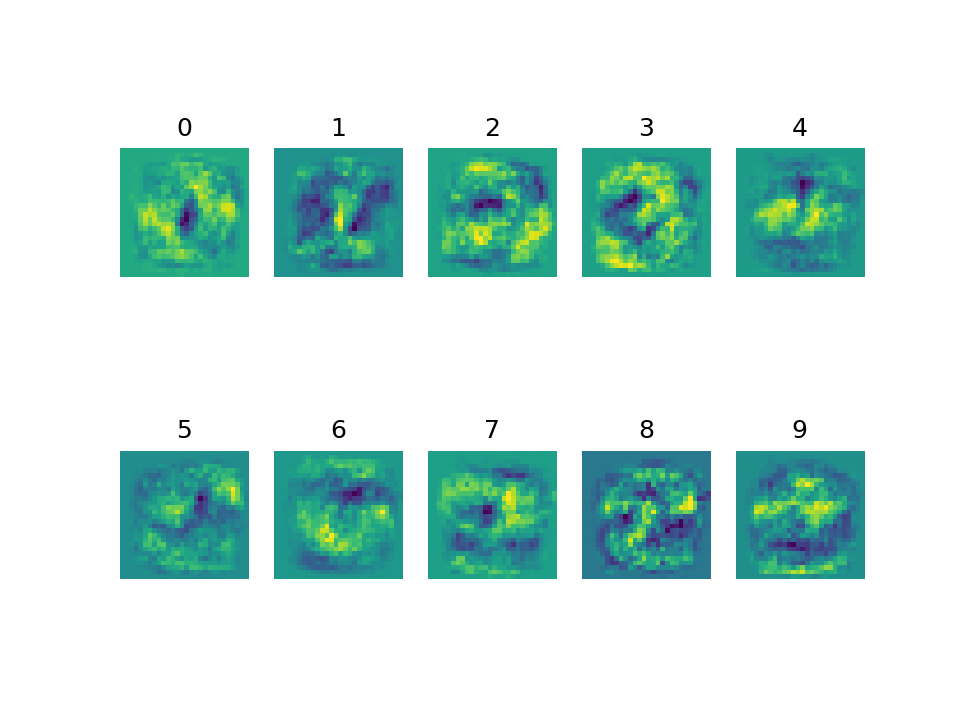

In [51]:
fig, axes = plt.subplots(2,5)
for i, (v, ax) in enumerate(zip(zs, axes.flat)):
    ax.imshow(v.view(28,28).numpy())
    ax.axis('off')
    ax.set_title(i)